In [1]:
import copy
import time

import numpy as np
import scipy
import skimage
import sklearn 
import matplotlib.pyplot as plt

In [2]:
def nondiag_sum(M):
    return np.sum(M) - np.sum(np.diagonal(M))
def nondiag_sq_sum(M):
    return (np.sum(np.square(M)) - np.sum(np.diagonal(np.square(M))))
def showmatrix(M, title=''):
    fig,ax = plt.subplots(1,2,figsize=(4,3),gridspec_kw={"width_ratios":[1, 0.05]})
    im = ax[0].imshow(M,vmin=0,vmax=1,cmap='hot')
    ax[0].set_title(title)
    fig.colorbar(im,cax=ax[1])
    plt.show()
def showsubset(M,best_elem_indices,title=''):
    s = np.sort(best_elem_indices)
    ixgrid = np.ix_(s, s)
    M_subset = M[ixgrid]
    showmatrix(M_subset, title=title)
    print('Nondiag sum:'+str(nondiag_sum(M_subset)))
    print('Nondiag sq. sum:'+str(nondiag_sq_sum(M_subset)))

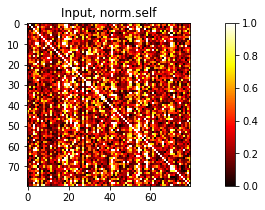

Nondiag sum:2319.4746031924665
Nondiag sq. sum:1407.2684207954303


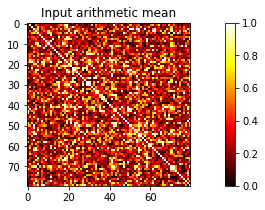

Nondiag sum:2319.4746031924665
Nondiag sq. sum:1310.6862988741289


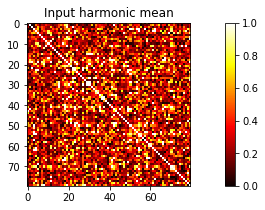

Nondiag sum:2230.0651343315553
Nondiag sq. sum:1214.1041769528274


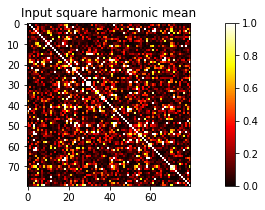

In [3]:
random_seed = 456
np.random.seed(random_seed)

N_elems = 80
#M = np.random.random((N_elems,N_elems))
#M = np.multiply(M, np.random.random()*0.5+0.5)
#M = np.multiply(M, np.transpose(M))
#M = M + np.random.random((N_elems,N_elems))*0.2
#M = M + np.diag(np.ones(N_elems)*0.4)

M = np.reshape(np.random.poisson(5,N_elems*N_elems),(N_elems,N_elems))
M = M + np.diag(np.ones(N_elems)*np.max(M)*0.15)
M = np.multiply(M, np.transpose(M))
M = M + np.diag(np.ones(N_elems)*np.max(M)*0.15)
M = M/np.max(M)

M_normself = np.diagonal(M)
M_normself = np.divide(M,M_normself)
showmatrix(M_normself, title='Input, norm.self')
print('Nondiag sum:'+str(nondiag_sum(M_normself)))
print('Nondiag sq. sum:'+str(nondiag_sq_sum(M_normself)))

M_sym_a = (M_normself + np.transpose(M_normself))/2
showmatrix(M_sym_a, title='Input arithmetic mean')
print('Nondiag sum:'+str(nondiag_sum(M_sym_a)))
print('Nondiag sq. sum:'+str(nondiag_sq_sum(M_sym_a)))

M_sym_h = np.sqrt(np.multiply(M_normself,np.transpose(M_normself)))
showmatrix(M_sym_h, title='Input harmonic mean')
print('Nondiag sum:'+str(nondiag_sum(M_sym_h)))
print('Nondiag sq. sum:'+str(nondiag_sq_sum(M_sym_h)))

M_sym_hs = np.multiply(M_normself,np.transpose(M_normself))
showmatrix(M_sym_hs, title='Input square harmonic mean')

In [4]:
N_elems_to_select = 20

costmatrix = M_sym_h

---
## Solution by a greedy heuristic
This uses an okayishly fast greedy heuristic (should be about _O(mn)_, where _n_ is how many elements we have and _m_ is how many we want to select):

    1) Find an element with the lowest cross-similarity sum. Use it as the "best" element.
    2) Iterate through all elements and find which element has lowest cross-similarity to the "best" element.
    3) Add this element to the list of "best" elements.
    4) Iterate through all elements and find which element has lowest cross-similarity sum to "best" elements; add it to the list.
    5) Repeat until we have the desired amount of "best" elements.

Greedy algorithm:
[ 0  6 10 12 14 16 23 26 28 31 40 48 55 59 60 63 64 67 72 76]


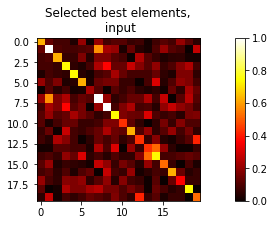

Nondiag sum:45.11743295366061
Nondiag sq. sum:8.250010767303339


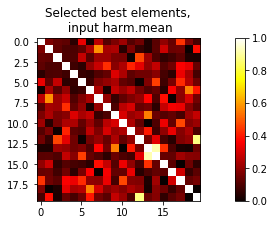

Nondiag sum:73.19905318495307
Nondiag sq. sum:21.315714566496823


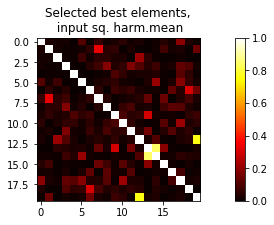

Nondiag sum:21.315714566496823
Nondiag sq. sum:4.784745767326527


In [9]:
def find_lowest_cross_similarity_greedy(costmatrix,N_elems_to_select):
    N_elems = costmatrix.shape[0]
    elem_cost_global = (np.sum(costmatrix, axis=0)-1)

    # First element guess is "the one that overall has the lowest cross-corr sum"
    best_elem_indices = np.zeros(1, dtype=np.int)
    best_elem_indices[0] = np.argmin(elem_cost_global)

    is_elem_available = np.full((N_elems,),True)
    is_elem_available[best_elem_indices[0]] = False

    for i in range(0,N_elems_to_select-1):
        test_elem_indices = is_elem_available.nonzero()[0]
        elem_cost_local = np.zeros(N_elems)
        for j in np.nditer(test_elem_indices):
            elem_cost_local[j] = np.sum(costmatrix[j,best_elem_indices])
        elem_cost_local[best_elem_indices] = np.inf
        best_candidate_index = np.argmin(elem_cost_local)

        is_elem_available[best_candidate_index] = False
        best_elem_indices = np.append(best_elem_indices,best_candidate_index)
    
    return best_elem_indices

best_elem_indices = find_lowest_cross_similarity_greedy(costmatrix,N_elems_to_select)        
print('Greedy algorithm:')
print(np.sort(best_elem_indices))
showsubset(M,best_elem_indices,title='Selected best elements,\n input')
showsubset(M_sym_h,best_elem_indices,title='Selected best elements,\n input harm.mean')
showsubset(M_sym_hs,best_elem_indices,title='Selected best elements,\n input sq. harm.mean')

---
## Solution by reduction to a quadratic program 
as per https://stats.stackexchange.com/questions/110426/least-correlated-subset-of-random-variables-from-a-correlation-matrix

Quadratic program minimization:
[ 0  1  6 10 12 13 14 20 39 45 46 48 56 57 66 68 72 73 75 76]


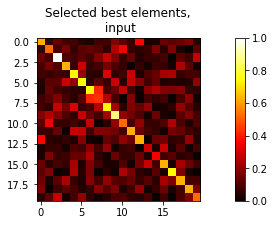

Nondiag sum:42.4518769353349
Nondiag sq. sum:7.184904002226199


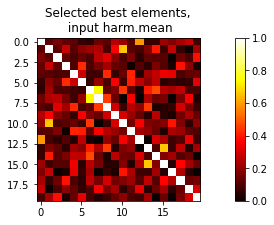

Nondiag sum:69.36913127726284
Nondiag sq. sum:19.310878335684393


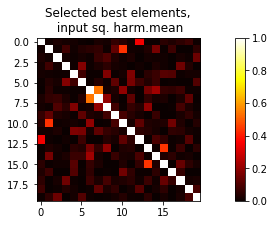

Nondiag sum:19.310878335684393
Nondiag sq. sum:3.1855079007189175


In [8]:
def find_lowest_cross_similarity(costmatrix,N_elems_to_select):
    # Quadratic program solution for the maximum edge weight clique problem
    # See https://stats.stackexchange.com/questions/110426/least-correlated-subset-of-random-variables-from-a-correlation-matrix
    def l1_sum_con(vec):
        return np.sum(vec) - N_elems_to_select
    def quadratic_costfunc(vec):
        return np.dot( np.dot(np.transpose(vec), costmatrix), vec)
    
    cons = [{'type':'eq', 'fun': l1_sum_con}]
    N_elems = costmatrix.shape[0]
    
    v0 = np.random.random(N_elems)
    bounds = scipy.optimize.Bounds(*np.transpose(np.repeat([[0,1]],N_elems,axis=0)))
    res = scipy.optimize.minimize(quadratic_costfunc, v0, constraints=cons, bounds=bounds)
    #print(res.message)
    #print(res.x)
    #plt.plot(res.x)
    best_elem_indices = np.argpartition(res.x, -N_elems_to_select)[-N_elems_to_select:]
    return best_elem_indices

best_elem_indices = find_lowest_cross_similarity(costmatrix,N_elems_to_select)
print('Quadratic program minimization:')
print(np.sort(best_elem_indices))
showsubset(M,best_elem_indices,title='Selected best elements,\n input')
showsubset(M_sym_h,best_elem_indices,title='Selected best elements,\n input harm.mean')
showsubset(M_sym_hs,best_elem_indices,title='Selected best elements,\n input sq. harm.mean')

---
## Solution by reduction to a quadratic program (random search)

Quadratic program random search:
[ 8 11 15 20 24 30 34 35 36 40 46 53 54 57 60 63 67 72 73 78]


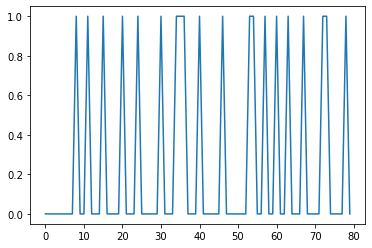

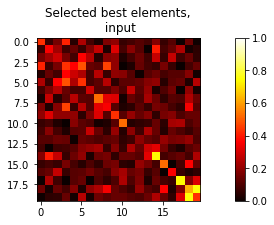

Nondiag sum:53.93694656212085
Nondiag sq. sum:11.606171586012664


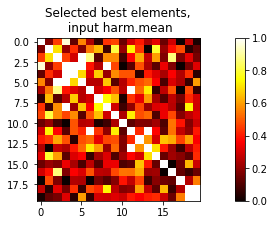

Nondiag sum:138.79100082406052
Nondiag sq. sum:75.5404072133503


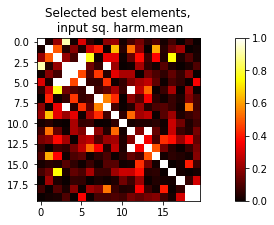

Nondiag sum:75.54040721335032
Nondiag sq. sum:46.07172774047032


In [7]:
def l1_sum_con(vec):
    return np.sum(vec) - N_elems_to_select

def quadratic_costfunc(vec):
    return np.dot( np.dot(np.transpose(vec), costmatrix), vec)

cons = {'type':'eq', 'fun': l1_sum_con}
rnd = np.random.random(N_elems)
v0 = np.zeros(N_elems)
v0[np.argpartition(rnd, -N_elems_to_select)[-N_elems_to_select:]] = 1

v = v0
bestv = v
N_attempts = 100000
for i in range(0,N_attempts):
    rnd = np.random.random(N_elems)
    v = np.zeros(N_elems)
    v[np.argpartition(rnd, -N_elems_to_select)[-N_elems_to_select:]] = 1
    if quadratic_costfunc(v) < quadratic_costfunc(bestv):
        v = bestv
    
plt.plot(bestv)
best_elem_indices = np.argpartition(bestv, -N_elems_to_select)[-N_elems_to_select:]

print('Quadratic program random search:')
print(np.sort(best_elem_indices))
showsubset(M,best_elem_indices,title='Selected best elements,\n input')
showsubset(M_sym_h,best_elem_indices,title='Selected best elements,\n input harm.mean')
showsubset(M_sym_hs,best_elem_indices,title='Selected best elements,\n input sq. harm.mean')